<a href="https://www.kaggle.com/code/mauddib/easy-gemma-2b-fine-tuning-python-questions?scriptVersionId=218512074" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents

1. [Load data](#loaddata)
2. [Visualize the score fields](#viz)
3. [Select questions and answers with positive scores](#select)
4. [Clean the questions and answers](#clean)
5. [Load model](#load)
6. [Get ready to train!](#get)

## Introduction  

OK so in this notebook we are just going to do some light exploration of the python questions and answers dataset which can be found here: https://www.kaggle.com/datasets/stackoverflow/pythonquestions?select=Answers.csv

Then we will prepare the gemma_2b_en weights to start fine tuning on our own dataset! Exciting! You can build your own data
set and thus improve on the baseline Gemma 2b weights!

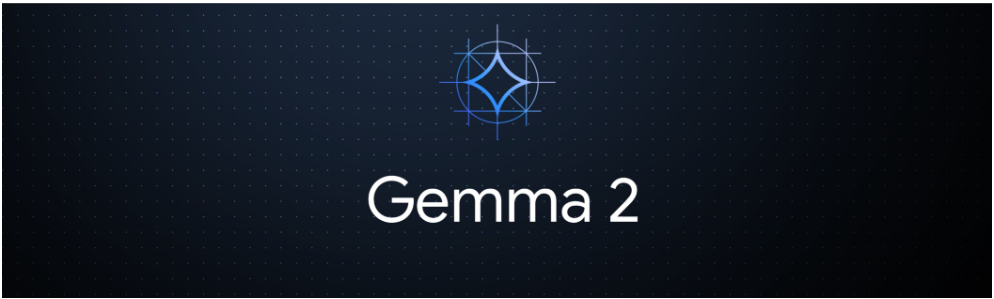

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pythonquestions/Answers.csv
/kaggle/input/pythonquestions/Questions.csv
/kaggle/input/pythonquestions/Tags.csv
/kaggle/input/gemma/keras/gemma_2b_en/2/config.json
/kaggle/input/gemma/keras/gemma_2b_en/2/tokenizer.json
/kaggle/input/gemma/keras/gemma_2b_en/2/metadata.json
/kaggle/input/gemma/keras/gemma_2b_en/2/model.weights.h5
/kaggle/input/gemma/keras/gemma_2b_en/2/assets/tokenizer/vocabulary.spm


# 1. Load data <a class="anchor"  id="loaddata"></a>

### So firstly lets load the data and see what it looks like:

In [2]:
ques = pd.read_csv('/kaggle/input/pythonquestions/Questions.csv',encoding='latin1')
display(ques.head())

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [3]:
answ = pd.read_csv('/kaggle/input/pythonquestions/Answers.csv',encoding='latin1')
display(answ.head())

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


# 2. Visualize the score fields <a class="anchor"  id="viz"></a>

In [4]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

### Lets describe the data:

In [5]:
display(ques.describe())

,Id,OwnerUserId,Score
count,6.072820e+05,6.010700e+05,607282.000000
mean,2.371960e+07,2.519595e+06,2.283137
std,1.124715e+07,1.910375e+06,19.285578
min,4.690000e+02,2.500000e+01,-44.000000
25%,1.485519e+07,8.539340e+05,0.000000
50%,2.531897e+07,2.107677e+06,1.000000
75%,3.358823e+07,3.991164e+06,2.000000
max,4.014336e+07,7.044992e+06,5524.000000


##### Looking at the score field we can see that there 600k rows. Trying to visualize this could take time so we employ random sampling in our visuals using .sample() :

Text(0.5, 1.0, 'Sample of Question score distribution')

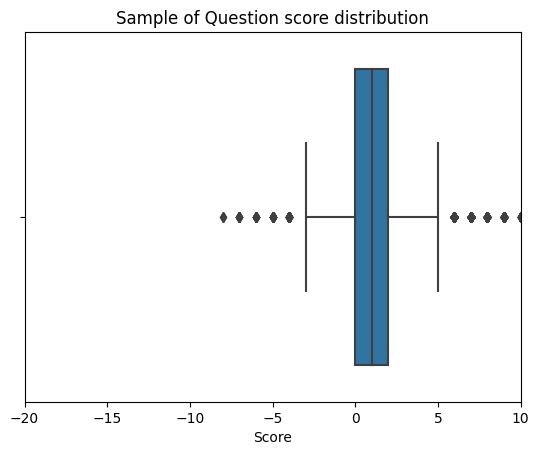

In [6]:
sns.boxplot(x=ques.Score.sample(n=20000))
plt.xlim(-20,10)

plt.title('Sample of Question score distribution')

##### So from the distribution above you can see that we have negative values, and even the 0 is potentially unwanted. Lets check out the answers score distribution:

Text(0.5, 1.0, 'Sample of Answer score distribution')

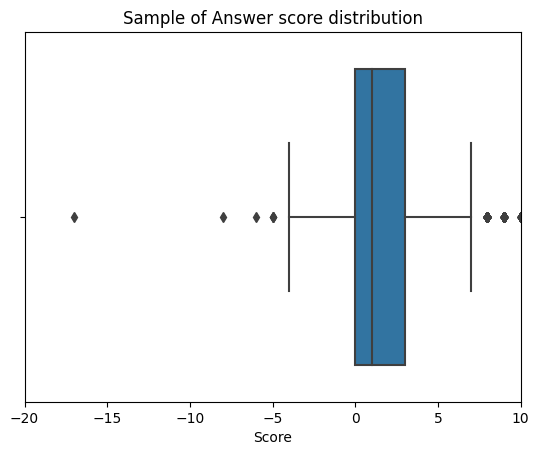

In [7]:
sns.boxplot(x=answ.Score.sample(n=20000))
plt.xlim(-20,10)
plt.title('Sample of Answer score distribution')

##### Uhuh, similar.

#### Another interesting way to look at how each of the answers fair as a whole:

In [8]:
answ.groupby('ParentId').agg({'Score': ['mean', 'min', 'max']}) 

Score        
               mean min max
ParentId                   
469        4.750000   1  12
502       12.000000   2  25
535       11.285714   2  23
594       15.333333   4  25
683        6.375000  -2  29
...             ...  ..  ..
40142906   1.000000   0   2
40142948   0.000000   0   0
40143133   1.000000   1   1
40143166   2.000000   2   2
40143190   2.500000   0   5

[539238 rows x 3 columns]

# 3. Select questions and answers with positive scores to train on: <a class="anchor"  id="select"></a>

#### OK lets drop the questions and answers with scores < 0

This is to ensure we dont have the weights train on questions/answers that are sub-par if you were wondering!

In [9]:
ques.drop(ques[ques['Score'] <= 0].index, inplace = True)
ques[ques['Score'] <= 0].head()

,Id,OwnerUserId,CreationDate,Score,Title,Body


In [10]:
ques[ques['Score'] > 0].head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [11]:
answ.drop(answ[answ['Score'] <= 0].index, inplace = True)
answ[answ['Score'] <= 0].head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body


In [12]:
answ[answ['Score'] > 0].head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


#### Now lets ensure the answers relate to questions that remain in the ques dataset:

In [13]:
answ = answ[answ.ParentId.isin(ques.Id)]
answ.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


#### What we are left with is a set of dfs with common Ids. (Id in questions and ParentId in answers)
And then we need to merge the data

In [14]:
combined = pd.merge(ques, answ, left_on='Id', right_on='ParentId', how='inner')
combined.head(2)

,Id_x,OwnerUserId_x,CreationDate_x,Score_x,Title,Body_x,Id_y,OwnerUserId_y,CreationDate_y,ParentId,Score_y,Body_y
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...


# 4. Clean the questions and answers <a class="anchor"  id="clean"></a>

#### so in this section i will be:
* stripping leading and trailing spaces
* replacing breaks (3rd piece of code)
* lowering the case of the letters
* removing HTML tags using re.sub

In [15]:
import re
combined['Body_x'] = combined['Body_x'].str.strip()
combined['Body_x'] = combined['Body_x'].str.lower()
combined['Body_x'] = combined['Body_x'].str.replace(r"<.*?>", " ", regex=True)

In [16]:
combined['Body_y'] = combined['Body_y'].str.strip()
combined['Body_y'] = combined['Body_y'].str.lower()
combined['Body_y'] = combined['Body_y'].str.replace(r"<.*?>", " ", regex=True)

In [17]:
final = (combined['Body_x'].apply(lambda x: f"Question: {x}\n") +  combined['Body_y'].apply(lambda x: f"Answer: {x}\n"))
final = final.replace('\n',' ', regex=True)
final.head(10)

0    Question:  i am using the photoshop's javascri...
1    Question:  i am using the photoshop's javascri...
2    Question:  i am using the photoshop's javascri...
3    Question:  i am using the photoshop's javascri...
4    Question:  i have a cross-platform (python) ap...
5    Question:  i have a cross-platform (python) ap...
6    Question:  i have a cross-platform (python) ap...
7    Question:  i'm starting work on a hobby projec...
8    Question:  i'm starting work on a hobby projec...
9    Question:  i'm starting work on a hobby projec...
dtype: object

#### Only take the first 3000 lines from the dataset to speed up training for illustratory purposes.

In [18]:
fin_list = final[:3000].to_list()
fin_list[0]


"Question:  i am using the photoshop's javascript api to find the fonts in a given psd.    given a font name returned by the api, i want to find the actual physical font file that that font name corresponds to on the disc.    this is all happening in a python program running on osx so i guess i'm looking for one of:      some photoshop javascript   a python function   an osx api that i can call from python    Answer:  open up a terminal (applications-&gt;utilities-&gt;terminal) and type this in: \r \r   locate insertfonthere   \r \r  this will spit out every file that has the name you want. \r \r  warning: there may be alot to wade through.  "

#### OK the text looks cleaner. Let's move on to doing some actual fine tuning. We first need to enable the Lora with rank.

# 5. Load model <a class="anchor"  id="load"></a>

In [19]:
import keras
import keras_nlp

In [20]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

#### Lets test the weights before we try fine tune them:

In [21]:
question="Write a Python program to test whether a number is prime or not."
answer=""
prompt = f"Question:\n{question}\n\n Answer:\n{answer}"
print(gemma_lm.generate(prompt, max_length=128))

Question:
Write a Python program to test whether a number is prime or not.

 Answer:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, n):
        if n % i == 0:
            return False
    return True

print(is_prime(10))



#### Lets test the code:

In [22]:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, n):
        if n % i == 0:
            return False
    return True

is_prime(7)

True

#### 7 is prime, who knew!

#### LoRA (Low-Rank Adaptation of Large Language Models) 
is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

In [23]:
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 1,363,968 (5.20 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

# 6. Get ready to train! <a class="anchor"  id="get"></a>

#### Now choose an optimizer, a common one used for fine tuning gemme 2b is the AdamW. Also choose a loss function.

In [24]:
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-6,
    weight_decay=0.01,
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

## Start training!

I chose a lowly 3 number of epochs to speed things up... but it looks much slower than that unfortunately... at least its training:

In [ ]:
gemma_lm.fit(fin_list, epochs=3, batch_size=1)

Epoch 1/3
   2/3000 ━━━━━━━━━━━━━━━━━━━━ 114:39:16 138s/step - loss: 0.4559 - sparse_categorical_accuracy: 0.4388

#### OK so I've stopped the training, as this will take hours and requires more resources than we can get for free from Kaggle! But you can see it all worked. Mission accomplished!

#### Next stop is to replicate the environment on my (your!) home PC and give it another go. I have a 6GB GPU which will hopefully allow me to train something over a couple of days. Ill revert here when im done with that. Until then, have fun!

<a href="https://imgflip.com/i/9hd963"><img src="https://i.imgflip.com/9hd963.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator"></a></div>